__оценка схожести изображений с помощью сиамской нейросети__

Евгений Борисов <esborisov@sevsu.ru>

---

Signature Verification using a "Siamese" Time Delay Neural Network   
Jane Bromley, Isabelle Guyon, Yann LeCun, Eduard Sickinger and Roopak Shah   
AT&T Bell Laboratories  
1994   

https://papers.nips.cc/paper/1993/file/288cc0ff022877bd3df94bc9360b9c5d-Paper.pdf

Gregory Koch  
Siamese Neural Networks for One-Shot Image Recognition  
2015 

http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf    

---

## библиотеки

In [1]:
# from os.path import join as pjoin
# from os import listdir
from itertools import combinations

import numpy as np
import numpy.random as rng

import gzip
import idx2numpy

from matplotlib import pyplot as plt

## загружаем учебный набор

In [2]:
# from tensorflow.keras.datasets import fashion_mnist
# _, (X,_ ) = fashion_mnist.load_data()

In [3]:
DATASET_FOLDER = '../data/fashion-mnist'

In [4]:
!ls ../data/fashion-mnist

t10k-images-idx3-ubyte.gz  train-images-idx3-ubyte.gz
t10k-labels-idx1-ubyte.gz  train-labels-idx1-ubyte.gz


In [6]:
# http://yann.lecun.com/exdb/mnist/

# картинки
with gzip.open( DATASET_FOLDER+'/train-images-idx3-ubyte.gz','rb') as f:
    x_train = np.expand_dims( idx2numpy.convert_from_string(f.read()), axis=-1 )

# метки
with gzip.open( DATASET_FOLDER+'/train-labels-idx1-ubyte.gz','rb') as f:
    y_train = idx2numpy.convert_from_string(f.read())
    
# нормируем картинки
x_train = (x_train-127.5)/127.5

x_train.min(), x_train.max(), x_train.shape , y_train.shape

(-1.0, 1.0, (60000, 28, 28, 1), (60000,))

In [7]:
n_samples, im_w, im_h, im_c = x_train.shape
n_samples, im_w, im_h, im_c

(60000, 28, 28, 1)

In [8]:
def ar2im(x): return ((x-x.min())/(x.max()-x.min())*255.).astype(np.uint8)

def plot_samples(X,n_show=15,columns=9,cmap='gray_r'):
    ii = rng.permutation(X.shape[0])[:n_show]
    plt.figure(figsize=(2*columns,2*(n_show //columns+1)))
    for n,xi in enumerate(X[ii]):
        img = ar2im(xi)
        plt.subplot( n_show//columns+1, columns, n+1)
        plt.axis(False)
        plt.imshow(img,cmap=cmap)

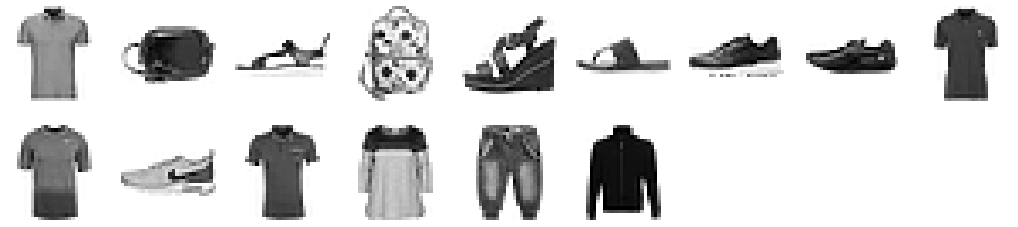

In [9]:
plot_samples(x_train)

In [10]:
x_train.shape

(60000, 28, 28, 1)

## строим учебный датасет

соберём два набора пар - похожие и непохожие картинки;

похожие пары собираем из одного класса, непохожие из разных классов

In [11]:
# позитивные примеры - пары одного класса
def sample_pos_class(x,y,c):
    xc = x[y==c] # выбираем примеры класса с
    n = xc.shape[0] # количество примеров класса с
    i = rng.permutation(n) # индексы примеров в случайном порядке
    return xc[i,:],xc 

def sample_pos(x,y):
    x_left,x_right = [],[]
    for c in set(y):
        xl,xr = sample_pos_class(x,y,c)
        x_left.append(xl)
        x_right.append(xr)
    return np.vstack(x_left),np.vstack(x_right)

In [12]:
# негативные примеры - пары разных классов

# размножить примеры класса
def reproduce_samples(x,dn):
    n = x.shape[0] 
    i = rng.permutation(n)[:dn]
    return np.vstack([x,x[i,:]])

def sample_neg_class(x,y,c0,c1):
    assert c0!=c1
    xc0 = x[y==c0] # выбираем примеры класса с0
    xc1 = x[y==c1] # выбираем примеры класса с1
    
    n0 = xc0.shape[0] # количество примеров класса с0
    n1 = xc1.shape[0] # количество примеров класса с1
    
    # выравниваем количества примеров в классах
    if n0>n1: # в классе с1 меньше примеров
        xc1 = reproduce_samples(xc1,n0-n1)
        n1=xc1.shape[0]
        
    if n0<n1: # в классе с0 меньше примеров
        xc0 = reproduce_samples(xc0,n1-n0)
        n0=xc0.shape[0]

    # индексы примеров в случайном порядке
    i0 = rng.permutation(n0) 
    i1 = rng.permutation(n1) 

    return xc0[i0,:],xc1[i1,:] 
    
# xl,xr = sample_neg_class(x_train,y_train,2,3)


def sample_neg(x,y,p=-1):
    cc = set(y) # список классов
    
    # все комбинации разных классов
    cc = list(combinations(cc,2))
    
    
    # ограничиваем количество пар
    if p>0: cc = rng.permutation(cc)[:p]

    x_left,x_right = [],[]
    for c0,c1 in cc:
        xl,xr = sample_neg_class(x,y,c0,c1)
        x_left.append(xl)
        x_right.append(xr) 
        
    return np.vstack(x_left),np.vstack(x_right)    

In [13]:
# картинки похожие, позитивные примеры
x_left_p, x_right_p = sample_pos(x_train,y_train)
target_p = np.ones((x_left_p.shape[0],1),dtype=np.float32)

x_left_p.shape, x_right_p.shape, target_p.shape  

((60000, 28, 28, 1), (60000, 28, 28, 1), (60000, 1))

In [14]:
# картинки не похожие негативные примеры
x_left_n,x_right_n = sample_neg(x_train,y_train)
target_n = np.zeros((x_left_n.shape[0],1),dtype=np.float32)

x_left_n.shape, x_right_n.shape, target_n.shape     

((270000, 28, 28, 1), (270000, 28, 28, 1), (270000, 1))

In [15]:
x_left_train  = np.vstack([x_left_n,  x_left_p])
x_right_train = np.vstack([x_right_n, x_right_p])
target_train  = np.vstack([target_n, target_p])

x_left_train.shape, x_right_train.shape, target_train.shape

((330000, 28, 28, 1), (330000, 28, 28, 1), (330000, 1))

In [16]:
def shuffle_dataset(x_left, x_right, target):
    ii = rng.permutation(x_left.shape[0])
    return x_left[ii,:],x_right[ii,:],target[ii,:]

## строим модель

In [17]:
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D 
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

from tensorflow.keras.layers import Lambda

# from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

# from tensorflow_addons.losses import contrastive_loss
# from tensorflow.keras.callbacks import TensorBoard

from tensorflow.keras.utils import plot_model

In [18]:
print('tensorflow',tf.__version__)
print('keras',tf.keras.__version__)

tensorflow 2.4.1
keras 2.4.0


In [20]:
# два входа модели
input_shape = (im_w,im_h,im_c)
# regularizer_rate = 2e-4
left_input, right_input = Input(input_shape), Input(input_shape)

In [21]:
# модель (свёрточная сеть) извлекающая признаки из картинок
encoder = Sequential(name='encoder')
encoder.add(Conv2D(64,(3,3),activation='relu',input_shape=input_shape)) 
encoder.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))    
encoder.add(Conv2D(128,(3,3),activation='relu')) 
encoder.add(Flatten())
encoder.add(Dense(512, activation='sigmoid'))

In [22]:
encoded_l = encoder(left_input) # левая ветка
encoded_r = encoder(right_input) # правая ветка

# считаем расстояние L1
L1_distance = Lambda(lambda t:K.abs(t[0]-t[1]),name='L1_distance')([encoded_l,encoded_r])
prediction = Dense(1,activation='sigmoid',)(L1_distance)

# собираем части в одну модель
model = Model(inputs=[left_input,right_input],outputs=prediction)

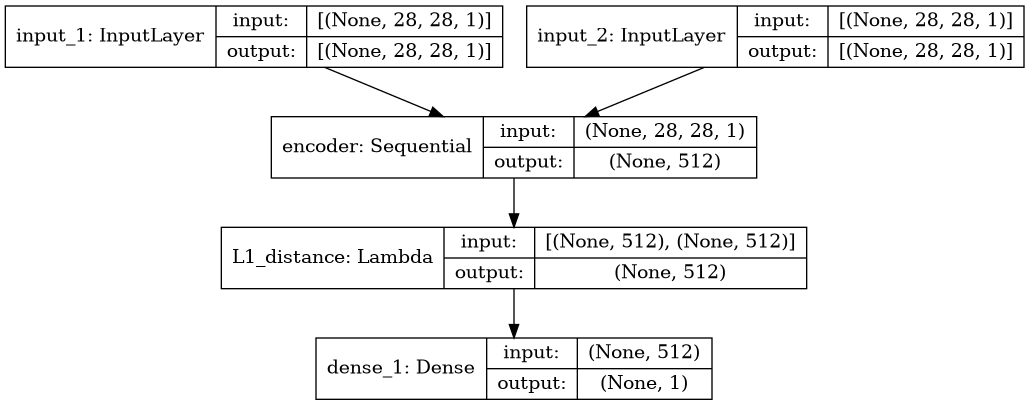

In [23]:
# model.summary()
plot_model(model, show_layer_names=True, show_shapes=True )

## обучаем модель

функция потери
$$
contrastive\_loss(y,p) = y \cdot p^2 + (1 - y) \cdot \max(0, m - p ) ^2
$$

In [24]:
# from tensorflow_addons.losses import contrastive_loss

def contrastive_loss(y, preds, margin=1):
    y = tf.cast(y, preds.dtype)
    squaredMargin = K.square(K.maximum(margin - preds, 0))
    return K.mean( y * K.square(preds) + (1-y)*squaredMargin)

In [25]:
x_left_train.shape, x_right_train.shape, target_train.shape

((330000, 28, 28, 1), (330000, 28, 28, 1), (330000, 1))

In [26]:
# дополнительно перемешиваем датасет
x_left_train,x_right_train,target_train = shuffle_dataset(x_left_train,x_right_train,target_train)

In [27]:
%%time

# обучаем модель

model.compile(loss=contrastive_loss,optimizer=Adam(lr=1e-5) )

history = model.fit( 
    [x_left_train, x_right_train], 
    target_train,
    epochs=5,
    batch_size=512,
)


Epoch 1/5
645/645 [==============================] - 37s 55ms/step - loss: 0.1519
Epoch 2/5
645/645 [==============================] - 35s 55ms/step - loss: 0.0941
Epoch 3/5
645/645 [==============================] - 35s 54ms/step - loss: 0.0816
Epoch 4/5
645/645 [==============================] - 35s 54ms/step - loss: 0.0727
Epoch 5/5
645/645 [==============================] - 35s 54ms/step - loss: 0.0674
CPU times: user 2min 6s, sys: 2.46 s, total: 2min 8s
Wall time: 2min 59s


In [42]:
# history.history

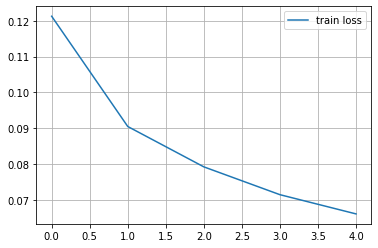

In [29]:
plt.plot(history.history['loss'],label='train loss')
# plt.plot(history.history['val_loss'],label='val loss')
plt.legend()
plt.grid()

## тестируем

In [34]:
# загружаем тестовый датасет

with gzip.open( DATASET_FOLDER+'/t10k-images-idx3-ubyte.gz','rb') as f:
    x_test = np.expand_dims( idx2numpy.convert_from_string(f.read()), axis=-1 )
    
with gzip.open( DATASET_FOLDER+'/t10k-labels-idx1-ubyte.gz','rb') as f:
    y_test = idx2numpy.convert_from_string(f.read())
    
x_test = (x_test-127.5)/127.5

x_test.min(), x_test.max(), x_test.shape, y_test.shape

(-1.0, 1.0, (10000, 28, 28, 1), (10000,))

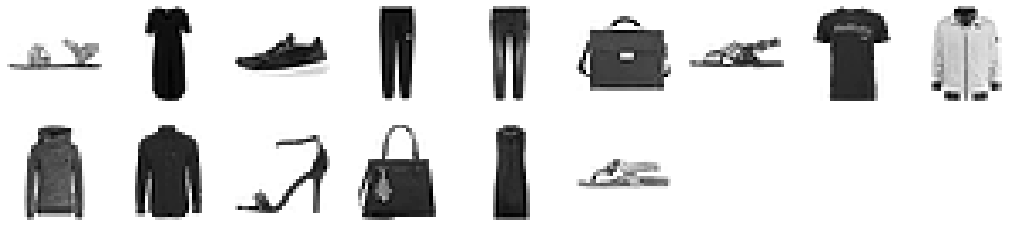

In [35]:
plot_samples(x_test)

In [36]:
# формируем похожие и непохожие пары картинок

x_left_p, x_right_p = sample_pos(x_test,y_test)
x_left_n,x_right_n = sample_neg(x_test,y_test)

x_left_test  = np.vstack([x_left_n,  x_left_p])
x_right_test = np.vstack([x_right_n, x_right_p])

x_left_test.shape, x_right_test.shape, # target_test.shape

((55000, 28, 28, 1), (55000, 28, 28, 1))

---

In [39]:
# меряем расстояния на тестовых парах
p = model.predict([x_left_test,x_right_test])
p.shape

(55000, 1)

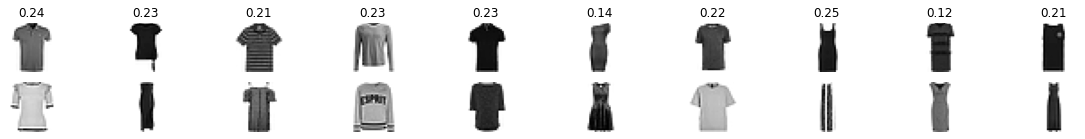

In [40]:
n_show = 10
cmap='gray_r'

# близкие картинки

ii = np.where(p.flatten()<.25)[0]
ii = rng.permutation(ii[:n_show])

fig,ax = plt.subplots(2,n_show,figsize=(n_show*2,2))
for n,i in enumerate(ii):
    imgL = ar2im(x_left_test[i,:])
    imgR = ar2im(x_right_test[i,:])
    
    ax[0][n].axis(False)
    ax[0][n].imshow(imgL,cmap=cmap)
    ax[0][n].set_title('%.2f'%p[i])
    
    ax[1][n].axis(False)
    ax[1][n].imshow(imgR,cmap=cmap)
    

# p[ii]    

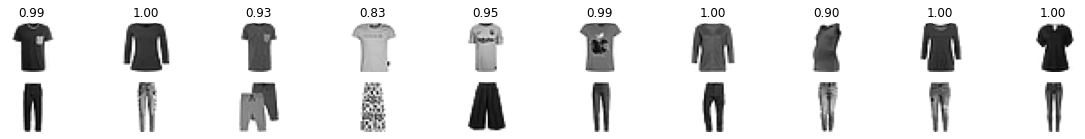

In [41]:
# далёкие картинки

ii = np.where(p.flatten()>.2)[0]
ii = rng.permutation(ii[:n_show])

fig,ax = plt.subplots(2,n_show,figsize=(n_show*2,2))
for n,i in enumerate(ii):
    imgL = ar2im(x_left_test[i,:])
    imgR = ar2im(x_right_test[i,:])
    
    ax[0][n].axis(False)
    ax[0][n].imshow(imgL,cmap=cmap)
    ax[0][n].set_title('%.2f'%p[i])
    
    ax[1][n].axis(False)
    ax[1][n].imshow(imgR,cmap=cmap)
    